In [2]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.pipeline import make_pipeline, make_union
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from mlxtend.feature_selection import ColumnSelector

from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.backend import clear_session
from tensorflow.keras import regularizers

from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.svm import SVR, LinearSVR
from xgboost import XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_PATH = os.path.abspath(os.path.join(os.getcwd(), '../'))

if PROJECT_PATH not in sys.path:
    sys.path.append(PROJECT_PATH)

from server.ml_models.player_model import PlayerModelData
from server.ml_models.betting_model import BettingModelData
from server.ml_models.match_model import MatchModelData

from src.model.metrics import regression_accuracy, measure_estimators, yearly_performance_scores
from src.model.charts import graph_yearly_model_performance, graph_tf_model_history, graph_cv_model_performance

START_DATE = '1965-01-01'
DATA_KWARGS = {'train_years': (None, None), 'test_years': (None, None)}

np.random.seed(42)

In [4]:
data = [
    BettingModelData(**DATA_KWARGS).data,
    PlayerModelData(start_date=START_DATE, **DATA_KWARGS).data,
    MatchModelData(**DATA_KWARGS).data,
]

/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Returning data from 1965-01-01 to 2016-12-31

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Finished getting afltables data

  warnings.warn(x, RRuntimeWarning)
/usr/local/lib/python3.6/site-packages/rpy2/robjects/pandas2ri.py:191: FutureWarning: from_items is deprecated. Please use DataFrame.from_dict(dict(items), ...) instead. DataFrame.from_dict(OrderedDict(items)) may be used to preserve the key order.
  res = PandasDataFrame.from_items(items)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'player_id' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  .groupby(["player_id", "year"], group_keys=True)
/app/server/data_processors/feature_functions.py:476: FutureWarning: 'year' is both an index level and a column label.
Defau

In [18]:
from functools import reduce

def concat_data_frames(agg_data_frame, data_frame):
    if agg_data_frame is None:
        return data_frame

    agg_cols = set(agg_data_frame.columns)
    df_cols = set(data_frame.columns)
    drop_cols = agg_cols.intersection(df_cols)
    # Have to drop shared columns, and this seems a reasonable way of doing it without hard-coding values
    return pd.concat([agg_data_frame.drop(list(drop_cols), axis=1), data_frame], axis=1)

data_frame = reduce(concat_data_frames, data)

data_frame_dtypes = data_frame.dtypes
numeric_cols_filter = ((data_frame_dtypes == float) | (data_frame_dtypes == int)).values
numeric_cols = data_frame.columns[numeric_cols_filter]
fillna_dict = {col: 0 for col in numeric_cols}

data_frame = data_frame.fillna(fillna_dict).loc[data_frame['year'] <= 2016, :]
data_frame

win_odds  line_odds  oppo_win_odds  \
team             year round_number                                       
Adelaide         1991 2                 0.00        0.0           0.00   
                      3                 0.00        0.0           0.00   
                      4                 0.00        0.0           0.00   
                      5                 0.00        0.0           0.00   
                      6                 0.00        0.0           0.00   
                      7                 0.00        0.0           0.00   
                      9                 0.00        0.0           0.00   
                      10                0.00        0.0           0.00   
                      11                0.00        0.0           0.00   
                      12                0.00        0.0           0.00   
                      13                0.00        0.0           0.00   
                      14                0.00        0.0           0.00   
                      15                0.00        0.0           0.00   
                      16                0.00        0.0           0.00   
                      17                0.00        0.0           0.00   
                      18                0.00        0.0           0.00   
                      19                0.00        0.0           0.00   
                      20                0.00        0.0           0.00   
                      21                0.00        0.0           0.00   
                      22                0.00        0.0           0.00   
                      24                0.00        0.0           0.00   
                 1992 1                 0.00        0.0           0.00   
                      3                 0.00        0.0           0.00   
                      4                 0.00        0.0           0.00   
                      5                 0.00        0.0           0.00   
                      6                 0.00        0.0           0.00   
                      7                 0.00        0.0           0.00   
                      8                 0.00        0.0           0.00   
                      9                 0.00        0.0           0.00   
                      10                0.00        0.0           0.00   
...                                      ...        ...            ...   
Western Bulldogs 2015 21                3.60       23.5           1.31   
                      22                2.30        6.5           1.63   
                      23                1.22      -28.5           4.50   
                      24                0.00        0.0           0.00   
                 2016 1                 1.65       -7.5           2.25   
                      2                 1.25      -25.5           3.95   
                      3                 1.96        1.5           1.88   
                      4                 1.08      -49.5           8.00   
                      5                 1.13      -42.5           6.25   
                      6                 2.05        2.5           1.81   
                      7                 1.72       -4.5           2.15   
                      8                 1.42      -16.5           2.95   
                      9                 3.10       18.5           1.38   
                      10                1.48      -13.5           2.70   
                      11                1.73       -5.5           2.15   
                      12                2.20        5.5           1.70   
                      13                2.40        9.5           1.60   
                      15                3.15       16.5           1.38   
                      16                1.20      -33.5           4.80   
                      17                1.11      -43.5           7.00   
                      18                1.35      -20.5           3.25   
                      19                

In [21]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 29918 entries, (Adelaide, 1991, 2) to (Western Bulldogs, 2016, 27)
Data columns (total 77 columns):
win_odds                                           29918 non-null float64
line_odds                                          29918 non-null float64
oppo_win_odds                                      29918 non-null float64
oppo_line_odds                                     29918 non-null float64
rolling_pred_win_rate                              29918 non-null float64
oppo_rolling_pred_win_rate                         29918 non-null float64
rolling_prev_match_kicks                           29918 non-null float64
rolling_prev_match_marks                           29918 non-null float64
rolling_prev_match_handballs                       29918 non-null float64
rolling_prev_match_goals                           29918 non-null float64
rolling_prev_match_behinds                         29918 non-null float64
rolling_prev_match_hit_outs         

In [22]:
# Create pipeline & reshape data inputs

from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow.keras.backend as K


CATEGORY_COLS = ['team', 'oppo_team', 'round_type']


class InputLister(BaseEstimator, TransformerMixin):
    def __init__(self, n_inputs=1):
        self.n_inputs = n_inputs
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [X[:, n] if n < self.n_inputs - 1 else X[:, n:] for n in range(self.n_inputs)]
    
    
def tip_accuracy(y, y_pred):
    correct_preds = ((y >= 0) & (y_pred >= 0)) | ((y <= 0) & (y_pred <= 0))
    return K.mean(correct_preds)


# Have to put categorical columns first to separate by type via index, then join after encoding the categories
organised_cols = CATEGORY_COLS + list(set(data_frame.columns) - set(CATEGORY_COLS))
organised_cols
    
n_teams = len(data_frame['team'].drop_duplicates())
n_round_types = len(data_frame['round_type'].drop_duplicates())

features = data_frame[organised_cols].drop(['score', 'oppo_score'], axis=1)
# Need team as segment value for TimeStepReshaper
labels = data_frame['score'] - data_frame['oppo_score']

feat_train = features[features['year'] < 2016]
feat_test = features[features['year'] == 2016]
lab_train = labels.loc[feat_train.index]
lab_test = labels.loc[feat_test.index]

n_features = len(features.columns)
n_labels = 1

cat_pipe = make_pipeline(ColumnSelector(cols=list(range(len(CATEGORY_COLS)))), OrdinalEncoder())
num_pipe = make_pipeline(ColumnSelector(cols=list(range(len(CATEGORY_COLS), n_features))), StandardScaler())

X_train = feat_train.values
X_test = feat_test.values
y_train = lab_train
y_test = lab_test

## NN without Regularization

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 23603 samples, validate on 5901 samples
Epoch 1/20
23603/23603 [==============================] - 2s 81us/step - loss: 27.5457 - tip_accuracy: 0.6830 - val_loss: 27.3508 - val_tip_accuracy: 0.7009
Epoch 2/20
23603/23603 [==============================] - 1s 61us/step - loss: 26.6190 - tip_accuracy: 0.7066 - val_loss: 27.2845 - val_tip_accuracy: 0.7028
Epoch 3/20
23603/23603 [==============================] - 2s 64us/step - loss: 26.4711 - tip_accuracy: 0.7085 - val_loss: 27.1305 - val_tip_accuracy: 0.7031
Epoch 4/20
23603/23603 [==============================] - 1s 60us/step - loss: 26.3243 - tip_accuracy: 0.7114 - val_loss: 27.0932 - val_tip_accuracy: 0.7043
Epoch 5/20
23603/23603 [==============================] - 1s 60us/step - loss: 26.2036 - tip_accuracy: 0.7132 - val_loss: 27.3414 - val_tip_accuracy: 0.7019
Epoch 6/20
23603/23603 [==============================] - 1s 63us/step - loss: 26.1424 - tip_accuracy: 0.7122 - val_loss: 27.1339 - val_tip_accuracy: 0.7007
Epoch 7/2

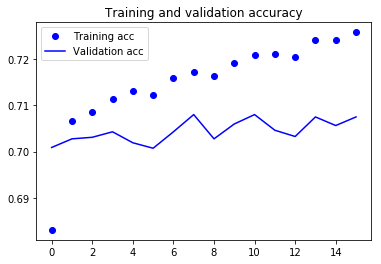

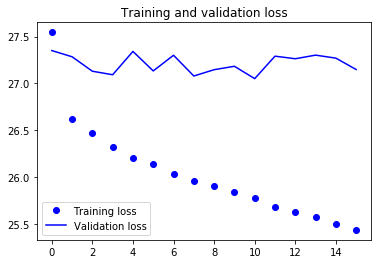

In [23]:
# Basic NN architecture

clear_session()

def create_nn_model():
    team_input = layers.Input(shape=(1,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(1,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(1,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_features - 3,), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(team_input)
    flatten_team_layer = layers.Flatten()(team_layer)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(oppo_team_input)
    flatten_oppo_team_layer = layers.Flatten()(oppo_team_layer)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=1)(round_type_input)
    flatten_round_layer = layers.Flatten()(round_type_layer)
    
    concated_layers = layers.concatenate(
        [flatten_team_layer, flatten_oppo_team_layer, flatten_round_layer, stats_input]
    )
    layer_1 = layers.Dense(75, input_shape=(n_features,), activation='relu')(concated_layers)
    layer_2 = layers.Dense(75, input_shape=(n_features,), activation='relu')(layer_1)
    layer_3 = layers.Dense(75, input_shape=(n_features,), activation='relu')(layer_2)
    output = layers.Dense(1)(layer_3)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


nn_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_nn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

nn_pipe.fit(X_train, y_train)

graph_tf_model_history(nn_pipe.steps[-1][1].model.history)

### Basic NN with dense layers performs better than RNN and CNN
In addition to better performance, the model trains much faster.

## NN with dropout

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

Train on 23603 samples, validate on 5901 samples
Epoch 1/20
23603/23603 [==============================] - 2s 87us/step - loss: 27.6399 - tip_accuracy: 0.6875 - val_loss: 27.7879 - val_tip_accuracy: 0.6946
Epoch 2/20
23603/23603 [==============================] - 2s 65us/step - loss: 26.7666 - tip_accuracy: 0.7062 - val_loss: 27.3918 - val_tip_accuracy: 0.7034
Epoch 3/20
23603/23603 [==============================] - 2s 67us/step - loss: 26.6130 - tip_accuracy: 0.7088 - val_loss: 27.4684 - val_tip_accuracy: 0.7011
Epoch 4/20
23603/23603 [==============================] - 2s 66us/step - loss: 26.4924 - tip_accuracy: 0.7094 - val_loss: 27.3920 - val_tip_accuracy: 0.6992
Epoch 5/20
23603/23603 [==============================] - 2s 69us/step - loss: 26.4037 - tip_accuracy: 0.7113 - val_loss: 27.1962 - val_tip_accuracy: 0.6995
Epoch 6/20
23603/23603 [==============================] - 2s 65us/step - loss: 26.3323 - tip_accuracy: 0.7120 - val_loss: 27.1911 - val_tip_accuracy: 0.7045
Epoch 7/2

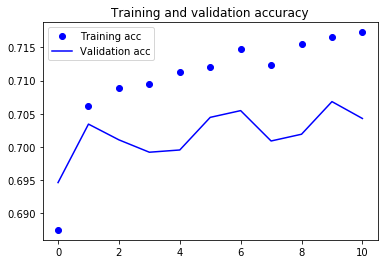

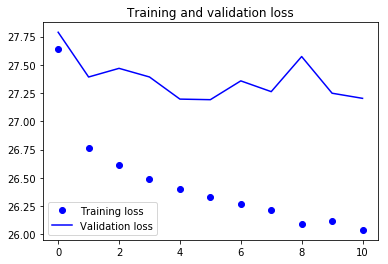

In [24]:
clear_session()

def create_dropout_nn_model():
    team_input = layers.Input(shape=(1,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(1,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(1,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_features - 3,), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(team_input)
    flatten_team_layer = layers.Flatten()(team_layer)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(oppo_team_input)
    flatten_oppo_team_layer = layers.Flatten()(oppo_team_layer)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=1)(round_type_input)
    flatten_round_layer = layers.Flatten()(round_type_layer)
    
    concated_layers = layers.concatenate(
        [flatten_team_layer, flatten_oppo_team_layer, flatten_round_layer, stats_input]
    )
    layer_1 = layers.Dense(75, input_shape=(n_features,), activation='relu')(concated_layers)
    dropout_1 = layers.Dropout(0.1)(layer_1)
    layer_2 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.1)(layer_2)
    layer_3 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_2)
    dropout_3 = layers.Dropout(0.1)(layer_3)
    output = layers.Dense(1)(dropout_3)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


do_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_dropout_nn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=5)])
)

do_pipe.fit(X_train, y_train)

graph_tf_model_history(do_pipe.steps[-1][1].model.history)

### Adding dropout makes performance slightly better
It reduces overfitting a little. The performance game is very small, but present.

## Try Classic ML Models
Since a simpler NN performs better than the more-complicated architectures, basic ensembles or even linear models might perform better still.

In [25]:
# Set up & split data for models

match_features = pd.get_dummies(data_frame.drop(['score', 'oppo_score'], axis=1)).astype(float)
match_labels = data_frame['score'] - data_frame['oppo_score']
match_data = train_test_split(match_features, match_labels)

In [26]:
# Pass data to models & measure performance

estimators = (Lasso(),
              ElasticNet(),
              Ridge(),
              LinearSVR(),
              AdaBoostRegressor(n_estimators=100),
              BaggingRegressor(),
              ExtraTreesRegressor(n_estimators=100),
              GradientBoostingRegressor(),
              RandomForestRegressor(n_estimators=100),
              SVR(kernel='rbf', gamma='auto'),
              XGBRegressor())
pipelines = [make_pipeline(StandardScaler(), estimator) for estimator in estimators]

estimator_scores = measure_estimators(pipelines, match_data, model_type='regression')
estimator_scores

Training lasso
lasso done
Training elasticnet
elasticnet done
Training ridge
ridge done
Training linearsvr
linearsvr done
Training adaboostregressor
adaboostregressor done
Training baggingregressor
baggingregressor done
Training extratreesregressor


/usr/local/lib/python3.6/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


extratreesregressor done
Training gradientboostingregressor
gradientboostingregressor done
Training randomforestregressor
randomforestregressor done
Training svr
svr done
Training xgbregressor
xgbregressor done


,estimator,accuracy,error,std_accuracy,std_error,score_type
0,lasso,0.704029,26.999712,0.004920,0.547201,cv
1,elasticnet,0.699929,27.194474,0.005126,0.482065,cv
2,ridge,0.706035,26.695051,0.007610,0.588291,cv
3,linearsvr,0.706035,26.727228,0.006838,0.567355,cv
4,adaboostregressor,0.693021,27.844003,0.007668,0.551972,cv
5,baggingregressor,0.681389,28.300547,0.005679,0.496459,cv
6,extratreesregressor,0.701712,27.017734,0.005742,0.419140,cv
7,gradientboostingregressor,0.710269,26.588732,0.008176,0.515084,cv
8,randomforestregressor,0.703227,26.944341,0.006250,0.437612,cv
9,svr,0.704831,27.482098,0.004535,0.457974,cv


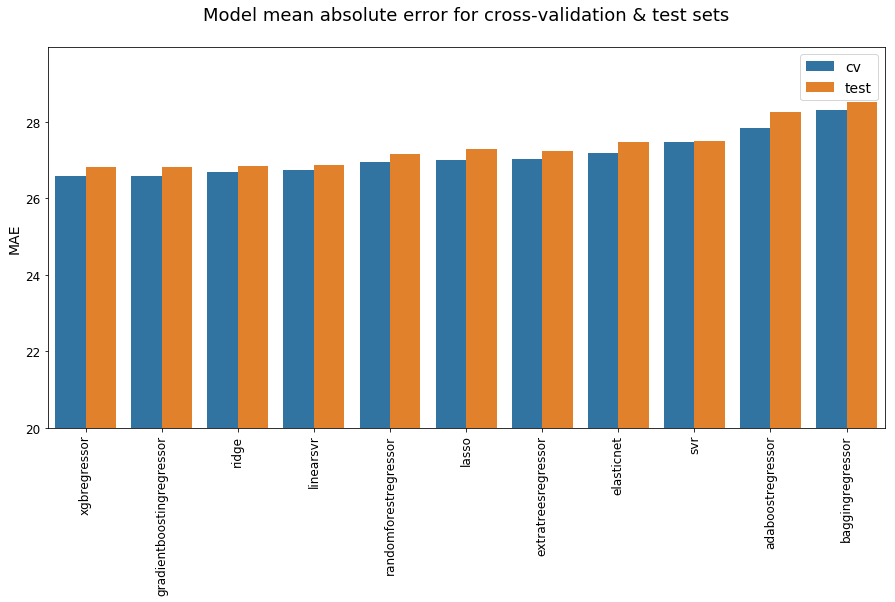

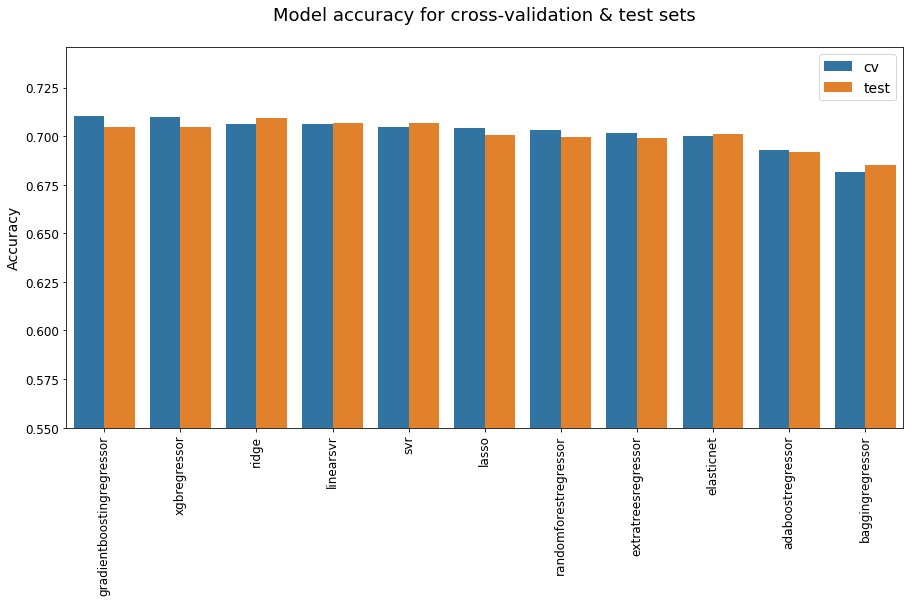

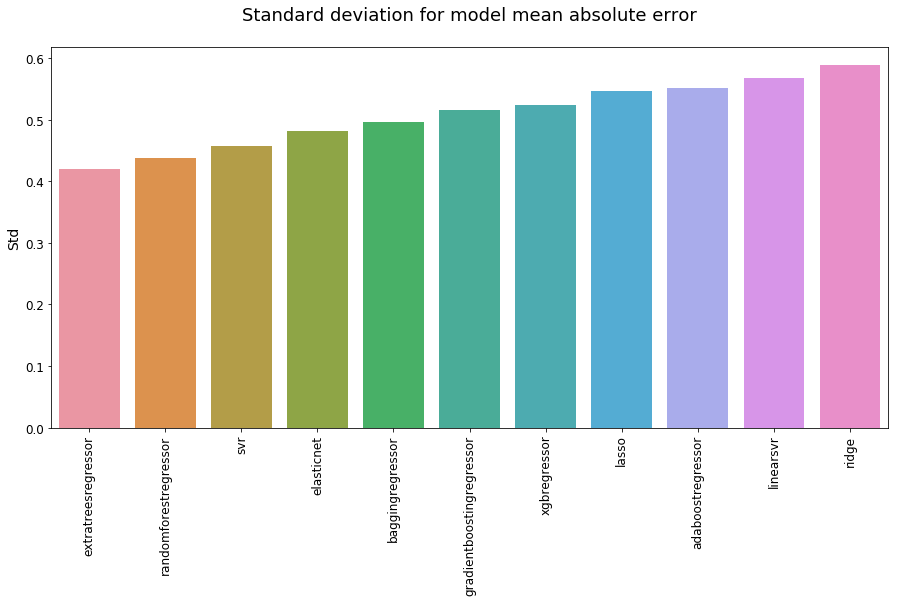

In [27]:
graph_cv_model_performance(estimator_scores)

## Yearly Performance Scores

In [28]:
def create_final_nn_model():
    team_input = layers.Input(shape=(1,), dtype='int32', name='team')
    oppo_team_input = layers.Input(shape=(1,), dtype='int32', name='oppo_team')
    round_type_input = layers.Input(shape=(1,), dtype='int32', name='round_type')
    stats_input = layers.Input(shape=(n_features - 3,), dtype='float32', name='stats')

    team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(team_input)
    flatten_team_layer = layers.Flatten()(team_layer)
    oppo_team_layer = layers.Embedding(n_teams * 2, 4, input_length=1)(oppo_team_input)
    flatten_oppo_team_layer = layers.Flatten()(oppo_team_layer)
    round_type_layer = layers.Embedding(n_round_types * 2, 4, input_length=1)(round_type_input)
    flatten_round_layer = layers.Flatten()(round_type_layer)
    
    concated_layers = layers.concatenate(
        [flatten_team_layer, flatten_oppo_team_layer, flatten_round_layer, stats_input]
    )
    layer_1 = layers.Dense(75, input_shape=(n_features,), activation='relu')(concated_layers)
    dropout_1 = layers.Dropout(0.1)(layer_1)
    layer_2 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_1)
    dropout_2 = layers.Dropout(0.1)(layer_2)
    layer_3 = layers.Dense(75, input_shape=(n_features,), activation='relu')(dropout_2)
    dropout_3 = layers.Dropout(0.1)(layer_3)
    output = layers.Dense(1)(dropout_3)

    model = models.Model(
        inputs=[
            team_input,
            oppo_team_input,
            round_type_input,
            stats_input
        ],
        outputs=output
    )
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[tip_accuracy])

    return model


final_pipe = make_pipeline(
    make_union(cat_pipe, num_pipe),
    InputLister(n_inputs=4),
    KerasRegressor(build_fn=create_final_nn_model,
                   epochs=20,
                   validation_split=0.2,
                   callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=3)])
)

estimators = [('nn', final_pipe, True)]
nn_year_scores = yearly_performance_scores(estimators, features, labels)

ml_estimators = [
    ('xgb', make_pipeline(StandardScaler(), XGBRegressor()), False),
    ('ridge', make_pipeline(StandardScaler(), Ridge()), False)
]
# Need to do this separately, because ML models use different data shape from NN model
ml_year_scores = yearly_performance_scores(ml_estimators, match_features, match_labels)

year_scores = pd.concat([nn_year_scores, ml_year_scores])
year_scores

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108:

,model,year,error,accuracy
0,nn,2011,31.414795,0.712821
1,nn,2012,28.733155,0.764563
2,nn,2013,26.394176,0.739130
3,nn,2014,28.837058,0.724638
4,nn,2015,30.183080,0.716019
5,nn,2016,28.709694,0.731884
0,xgb,2011,30.605964,0.723077
1,ridge,2011,28.933043,0.769231
2,xgb,2012,28.348135,0.783981
3,ridge,2012,28.161787,0.747573


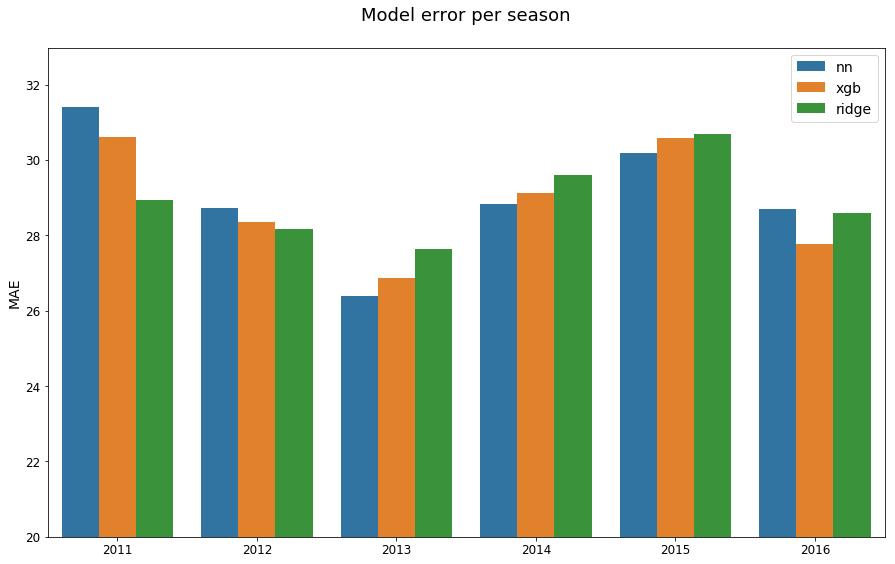

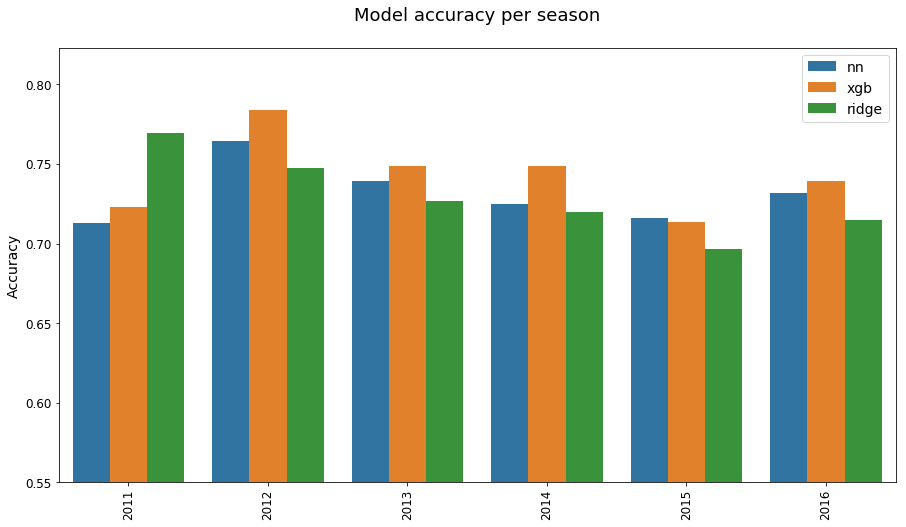

In [29]:
graph_yearly_model_performance(year_scores)

### XGB performs slightly better than NN
It's pretty close, but it looks like XGB performs a little better than a multi-layered neural net. The NN has slightly lower MAE most years, but XGB has a lower overall MAE, and XGB has a strong advantage in yearly accuracy. Also, XGB tends to train faster and, though it has a lot of parameters to tune, it's still less complex than a nn, whose potential parameters and structures require a whole lot of experimentation and tuning.

## Yearly Performance Comparison

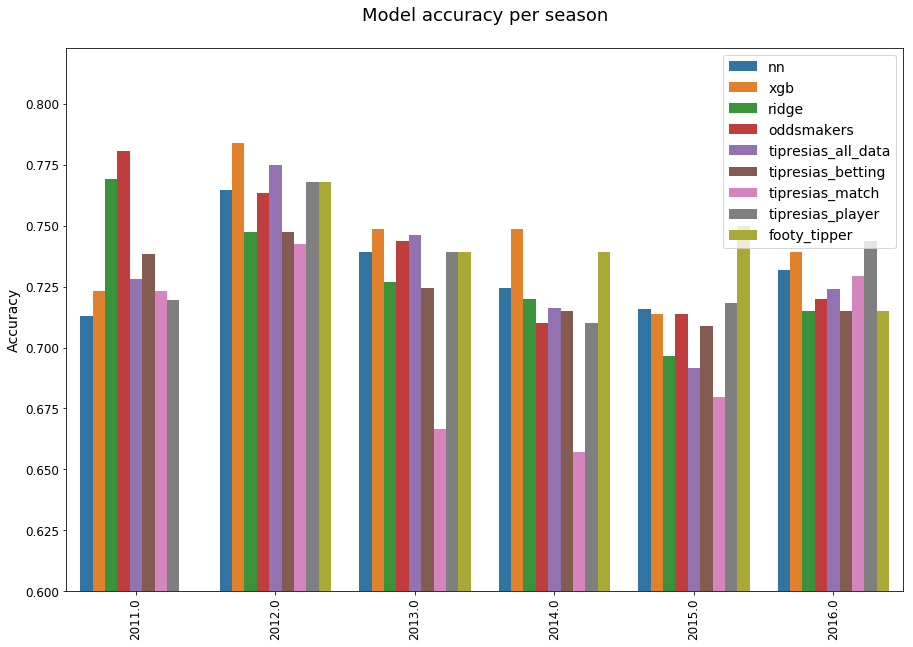

In [30]:
prediction_df = pd.read_csv('../data/model_predictions.csv')
prediction_scores = (prediction_df
                     .groupby(['model', 'year'])
                     .mean()['tip_point']
                     .reset_index()
                     .rename(columns={'tip_point': 'accuracy'}))
# Footy tipper accuracy scores taken from a trial that took too long to run,
# so I'm just copy pasting from a notebook
footy_tipper_scores = pd.DataFrame({'model': ['footy_tipper'] * len(range(2012, 2017)),
                                    'year': list(range(2012, 2017)),
                                    'error': [0] * len(range(2012, 2017)),
                                    'accuracy': [0.768116, 0.739130, 0.739130, 0.750000, 0.714976]})

all_year_scores = (pd
                   .concat([year_scores, prediction_scores, footy_tipper_scores],
                           sort=True)
                   .reset_index(drop=True))

# Accuracy scores
plt.figure(figsize=(15, 10))
sns.barplot(x='year', y='accuracy', hue='model', data=all_year_scores[all_year_scores['year'] > 2010])
# Not starting axis at 0 to make small relative differences clearer
plt.ylim(bottom=0.6)
plt.title('Model accuracy per season\n', fontsize=18)
plt.ylabel('Accuracy', fontsize=14)
plt.xlabel('', fontsize=14)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12, rotation=90)
plt.legend(fontsize=14)

plt.show()

### XGB trained on all data compares well to other models
It's the most-accurate model for 2012, 2013, and 2014, and it comes in 2nd in 2016.